In [1]:
import numpy as np
from agents import *
import matplotlib.pyplot as plt

In [2]:
# Implementing a controllable 2D random walk

# Environment Model
A = np.array([[1.9, 0], [0, 1.9]])
B = np.array([[1, 0], [0, 1]])
Sp = np.array([[3., 0], [0, 3.]])

mu0 = np.array([10., 10.])
Sp0 = np.array([[3, 0], [0, 3]])

T = 20

# Cost function
Qx = np.array([[1, 0], [0, 1]])
Qu = np.array([[1, 0], [0, 1]])
QT = np.array([[0.0001, 0], [0, 0.0001]])

# Controlling:
S = np.zeros([T+1, 2, 2])
L = np.zeros([T+1, 2, 2])
S[T] = QT
for k in range(T-1, -1, -1):
    S[k] = A.T.dot(S[k+1] - S[k+1].dot(B).dot(np.linalg.inv(B.T.dot(S[k+1].dot(B)) + Qu).dot(B.T).dot(S[k+1]))).dot(A) + Qx
    L[k] = np.linalg.inv(B.T.dot(S[k+1].dot(B)) + Qu).dot(B.T.dot(S[k+1].dot(A)))

In [3]:
# Sensing Models (each per agent, everybody has an H and R, thus a K!
def getBeliefParams(Sz, Sz0):
    P = np.zeros([T+1, 2, 2])
    K = np.zeros([T, 2, 2])
    P[0] = Sz0
    for k in range(T):
        P[k+1] = A.dot(P[k] - P[k].dot(np.linalg.inv(P[k] + Sz).dot(S[k]))).dot(A.T) + Sp
        K[k] = P[k].dot(np.linalg.inv(P[k] + Sz))
    return [K, P]


def measureAndEstimate(state, prev, K, L, Sz_bis):
    obs = state + Sz_bis.dot(np.random.randn(2))
    return (A - B.dot(L) - K.dot(A) + K.dot(B.dot(L))).dot(prev) + K.dot(obs)

N = 5
Szs = np.array([.1, .3, .2, .5, .1])
Szs_bis = np.sqrt(Szs)
Sz0s = .1 * np.ones(N)

BeliefParams = [getBeliefParams(Szs[i] * np.eye(2), Sz0s[i] * np.eye(2)) for i in range(N)]

# Communication matrix
COMM = np.array([[1/N, 1/N, 1/N, 1/N, 1/N],
                 [1/N, 1/N, 1/N, 1/N, 1/N],
                 [1/N, 1/N, 1/N, 1/N, 1/N],
                 [1/N, 1/N, 1/N, 1/N, 1/N],
                 [1/N, 1/N, 1/N, 1/N, 1/N]])

Rounds = 1

In [4]:
# Simulation:
X = np.zeros([T, 2])
# X_ = [np.zeros([T, 2]) for i in range(N)]

X[0] = mu0 + np.sqrt(Sp0).dot(np.random.randn(2))
U = np.zeros(2)
Sp_bis = np.sqrt(Sp)

for k in range(1, T):
    X[k] = A.dot(X[k-1]) + B.dot(U) + Sp_bis.dot(np.random.randn(2))

    """
    # Compute local estimates
    for i in range(N):
        X_[i][k] = measureAndEstimate(X[k], X_[i][k-1], BeliefParams[i][0][k], L[k], Szs_bis[i]*np.eye(2))

    # Share info
    for _ in range(Rounds):
        Collective = []
        for i in range(N):
            Collective.append(np.sum([COMM[i, j] * X_[j][k] for j in range(N)], axis=0))

        for i in range(N):
            X_[i][k] = Collective[i]
    """
    U = -L[k].dot(X[k])

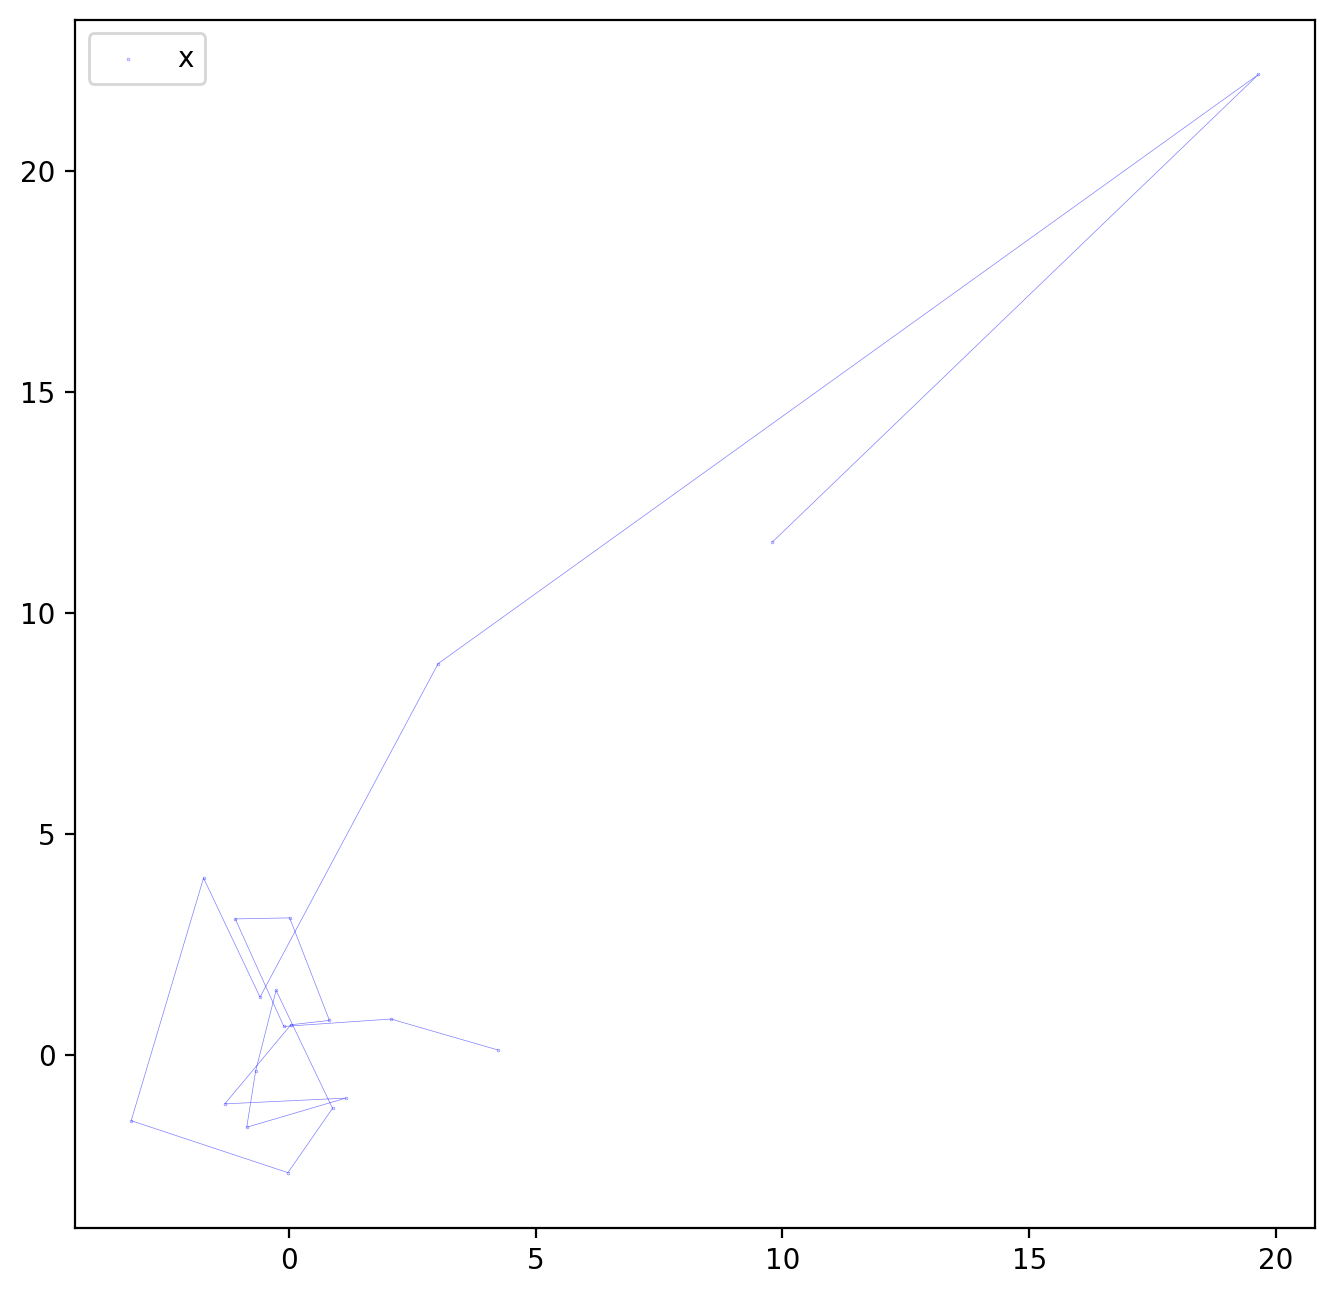

In [5]:
# Path
fig = plt.figure(figsize=(8,8),dpi=200)
ax = fig.add_subplot(111)

"""
for i in range(N):
    ax.scatter(X_[i][:,0], X_[i][:,1], alpha=1, s=0.5, label='x_')
    ax.plot(X_[i][:,0], X_[i][:,1], alpha=0.5, ls='-')

ax.scatter(X[:,0], X[:,1],c="blue",alpha=0.5,s=0.05, label='x')
ax.plot(X[:,0], X[:,1],c="blue",alpha=0.5,lw=0.25,ls='-')
ax.plot(X[0,0], X[0,1],c="crimson", marker="^", label='start')
ax.plot(X[-1,0], X[-1,1],c="black", marker="o", label='end')
"""
ax.scatter(X[:,0], X[:,1],c="blue",alpha=0.5,s=0.05, label='x')
ax.plot(X[:,0], X[:,1],c="blue",alpha=0.5,lw=0.25,ls='-')

plt.legend()
plt.show()

array([[11.22404028, 10.04543999],
       [10.05552165,  9.1775435 ],
       [ 3.0829521 ,  3.72320164],
       [-0.21310593,  2.32006183],
       [ 4.1182515 ,  4.49634331],
       [ 1.65082932,  4.63459848],
       [ 0.41091219,  1.75214797],
       [-2.17462766,  0.45890466],
       [ 0.14478672,  3.63651697],
       [-0.53575762,  1.75426185],
       [-0.76340832,  1.93598156],
       [ 1.40813799,  0.15887905],
       [ 0.62150935, -2.72750939],
       [-0.92886099, -5.36967957],
       [ 3.16558715,  0.02272935],
       [-0.41331982,  1.99884822],
       [ 2.74811621, -1.34942368],
       [-0.12351412, -0.37904803],
       [-1.11180085, -3.38884858],
       [-2.10868531,  0.87652592]])

In [ ]:
import numpy as np

class Agent:
    def __init__(self, id, pos0, vel0):
        self.id = id
        self.pos = pos0
        self.vel = vel0
        self.neighbors = []

    def step(self, u):
        self.vel = u
        self.pos += self.vel

    def measure(self):
        pass

E = 0.1
C1 = 0.3
C2 = 0.3
C1T = 0.3
C2T = 0.3
H = 0.7
R = 8
PRED_MAX_VEL = 5
final_pos = np.array([0,0])

def signorm(x):
    return 1/(E * (np.sqrt(1 + E * np.linalg.norm(x)**2) - 1))

def gforce(x):
    return np.sign(x)

def bumpfunc(z):
    if 0 <= z < H:
        return 1
    elif H <= z < 1:
        return (1 + np.cos(np.pi * (z - H) / (1 - H)))/2

In [56]:
N = 5
agents = [Agent(idx, np.random.uniform(-10, 10, 2), np.random.uniform(0, 5, 2)) for idx in range(N)]

In [58]:
i = 1
neighbors = []
obstacles = []

fg = C1 * sum([gforce(signorm(agents[j].vel - agents[i].vel))*(agents[j].pos - agents[i].pos)/np.sqrt(1 + E * np.linalg.norm(agents[j].pos - agents[i].pos)**2) for j in neighbors])
fo = sum([bumpfunc(signorm(pos - agents[i].pos) / signorm(R)) * (PRED_MAX_VEL - agents[i].vel) for pos in obstacles])
fd = C2 * sum([bumpfunc(signorm(agents[j].pos - agents[i].pos) / signorm(R)) * (agents[j].vel - agents[i].vel) for j in neighbors])
ft = - C1T * (agents[i].pos - final_pos) - C2T * agents[i].vel

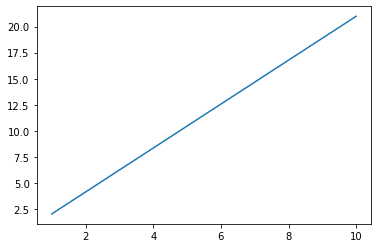

In [6]:
plt.plot([1, 10], [2, 21])

In [10]:
import numpy as np
A = np.array([[0, -1, 0, -1], [-1, 0, 0, -1], [0, -1, 0, 0], [-1, 0, -1, 0]])
print(A)
res = A - np.sum(A, axis=1) * np.eye(4)

[[ 0 -1  0 -1]
 [-1  0  0 -1]
 [ 0 -1  0  0]
 [-1  0 -1  0]]


In [11]:
max(np.diag(res))


2.0